In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import DBSCAN

In [28]:
file_name = 'data/rail_with_clips.csv'
df = pd.read_csv(file_name)

In [29]:
# convert from meters to feet and rename
df[['lateral', 'axial', 'vertical']] = df[['X', 'Y', 'Z']] * 3.28084

In [30]:
# set scales to start at zero
df['vertical'] = df['vertical'] - df['vertical'].min() # set min to 0
df['axial'] = df['axial'] - df['axial'].min() # set min to 0

In [31]:
drop_cols = ['X', 'Y', 'Z', 'R', 'B', 'G', 'Nx', 'Ny', 'Nz', 'Classification_confidence', 'Original_cloud_index', 'Intensity', 'Illuminance_(PCV)']
df = df.drop(columns=drop_cols)

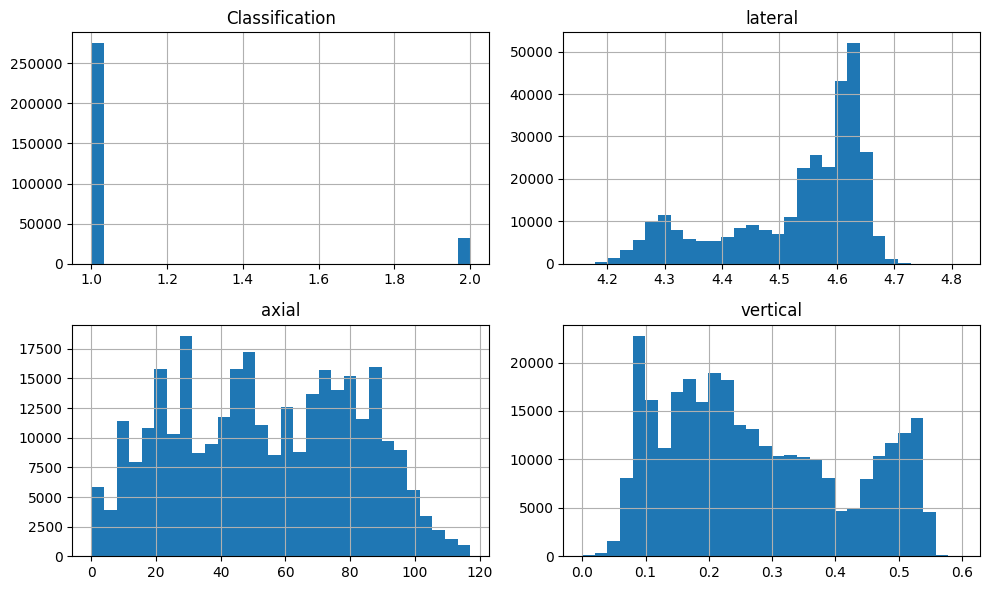

In [32]:
# Histograms for each column
df.hist(bins=30, figsize=(10, 6))
plt.tight_layout()
plt.show()

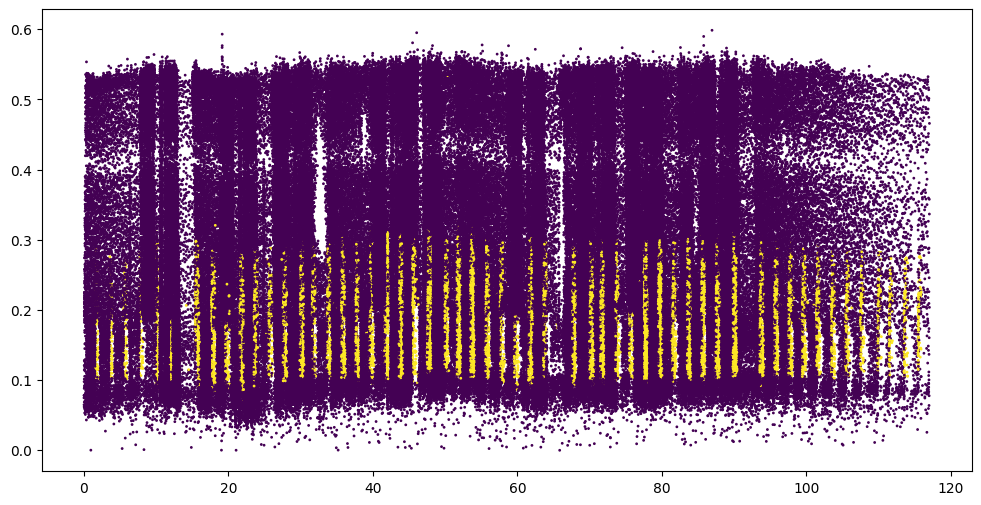

In [33]:
plt.figure(figsize=(12, 6))
plt.scatter(df['axial'], df['vertical'], c=df['Classification'], cmap='viridis', s=1)
plt.show()

In [34]:
df_clips = df[df['Classification'] == 2].copy()

In [35]:
df_clips

,Classification,lateral,axial,vertical
6,2,4.567242,113.585806,0.205988
7,2,4.290865,115.527350,0.195065
29,2,4.466382,115.475602,0.122797
30,2,4.304064,113.746348,0.253165
36,2,4.265448,113.929695,0.160344
...,...,...,...,...
283370,2,4.264240,5.786682,0.109849
283371,2,4.567887,1.716282,0.207002
283372,2,4.291027,5.979507,0.102401
283373,2,4.230214,1.728729,0.199286


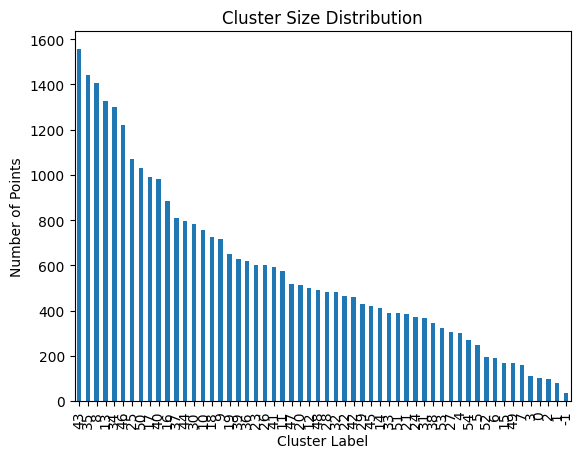

54


In [36]:
dbscan_params = {
    'eps': 0.3,  # maximum distance between two samples for one to be considered as in the neighborhood of the other
    'min_samples': 10  # minimum number of samples in a neighborhood for a point to be considered as a core point
}

clustering = DBSCAN(eps=dbscan_params['eps'], min_samples=dbscan_params['min_samples'])
df_clips['cluster'] = clustering.fit_predict(df_clips[['axial']])
df_clips['cluster'].value_counts().plot(kind='bar')
plt.title('Cluster Size Distribution')  
plt.xlabel('Cluster Label')
plt.ylabel('Number of Points')
plt.show()
print(df_clips['cluster'].max())


In [37]:
# Compute the mean axial value per cluster and sort
cluster_order = df_clips.groupby('cluster')['axial'].mean().sort_values().reset_index()
cluster_order['cluster_order'] = range(len(cluster_order))

# Map the cluster order back to the original DataFrame
df_clips = df_clips.merge(cluster_order[['cluster', 'cluster_order']], on='cluster', how='left')

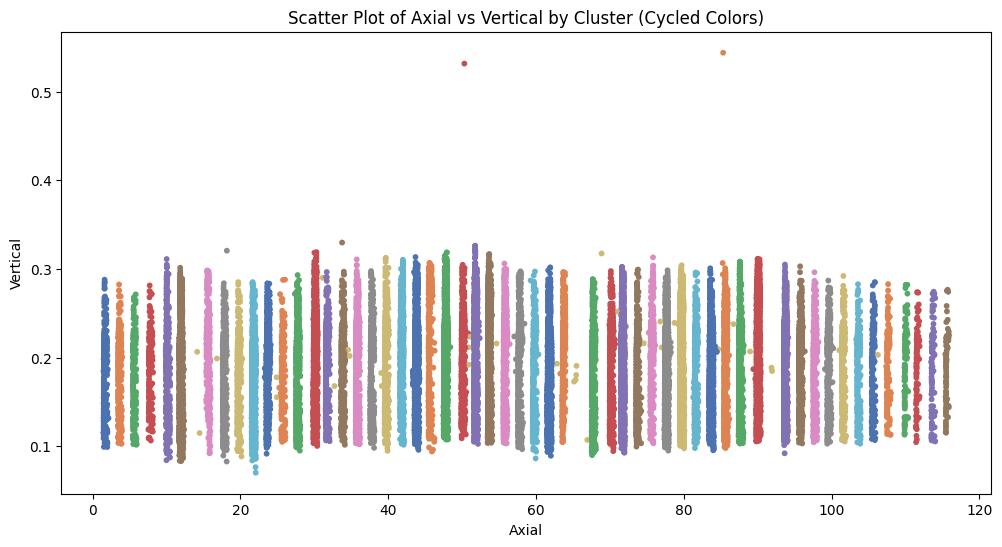

In [46]:
# Define a list of 10 non-random colors
color_cycle = sns.color_palette("deep")

# Get unique clusters and assign colors cyclically
unique_clusters = df_clips.groupby('cluster')['axial'].mean().sort_values().index
cluster_color_map = {cluster: color_cycle[i % len(color_cycle)] for i, cluster in enumerate(unique_clusters)}

# Map colors to each row
colors = df_clips['cluster'].map(cluster_color_map)

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(df_clips['axial'], df_clips['vertical'], c=colors, s=10)
plt.title('Scatter Plot of Axial vs Vertical by Cluster (Cycled Colors)')
plt.xlabel('Axial')
plt.ylabel('Vertical')
plt.show()


In [44]:
clip_locations = df_clips.groupby('cluster_order')['axial'].mean().copy().round(1)
clip_locations

cluster_order
0       1.7
1       3.6
2       5.6
3       7.8
4      10.1
5      12.0
6      15.7
7      17.8
8      19.8
9      21.8
10     23.7
11     25.7
12     27.7
13     30.1
14     31.7
15     33.9
16     35.8
17     37.8
18     39.7
19     41.9
20     43.8
21     45.7
22     47.8
23     50.1
24     51.8
25     53.7
26     55.8
27     57.8
28     58.9
29     59.8
30     61.8
31     63.7
32     67.8
33     70.2
34     71.8
35     73.7
36     75.7
37     77.7
38     79.7
39     81.6
40     83.7
41     85.6
42     87.6
43     90.1
44     93.7
45     95.8
46     97.7
47     99.6
48    101.6
49    103.6
50    105.6
51    107.6
52    110.0
53    111.6
54    113.7
55    115.6
Name: axial, dtype: float64

In [56]:
import plotly.graph_objects as go

# Create the plot
fig = go.Figure()

# Add tick marks as dots on a horizontal line
fig.add_trace(go.Scatter(
    x=clip_locations.values,
    y=[0] * len(clip_locations),
    mode='markers',
    marker=dict(size=10),
    name='Mean Axial Positions'
))

fig.update_layout(
    title='Mean Axial Positions by Cluster Order',
    xaxis_title='Axial Value',
    yaxis=dict(showticklabels=False, showgrid=True, zeroline=True),
    height=200,

)

fig.show()
